In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from juanfit import SpectrumFit2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, 
                                AutoLocator, MaxNLocator)
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval,\
         ManualInterval, SqrtStretch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmasher as cmr
import cmcrameri.cm as cmcm
import astropy.constants as const

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
FeX_6374_file = "../../sav/AWSoM/syn_fit/box_run0039_run01_75_5th_spm/spm_phx_7_n0115001.sav"
FeXIV_5303_file = "../../sav/AWSoM/syn_fit/box_run0039_run01_75_5th_spm/spm_phx_8_n0115001.sav"

In [4]:
FeXIV_5303_idlsav = readsav(FeXIV_5303_file)
FeXIV_5303_wvl = FeXIV_5303_idlsav["x"][2,:,0,0]
FeXIV_5303_x_mesh = FeXIV_5303_idlsav["x"][0,0,:,:]
FeXIV_5303_y_mesh = FeXIV_5303_idlsav["x"][1,0,:,:]
FeXIV_5303_profiles = FeXIV_5303_idlsav["w"]

In [5]:
FeXIV_5303_profiles.shape

(25, 253, 211)

In [6]:
mask_disk = np.where(np.sqrt(FeXIV_5303_x_mesh**2 + FeXIV_5303_y_mesh**2) < 1.03)

In [7]:
FeXIV_int_sum = np.sum(FeXIV_5303_profiles,axis=0)*0.25
FeXIV_int_sum[mask_disk] = np.nan

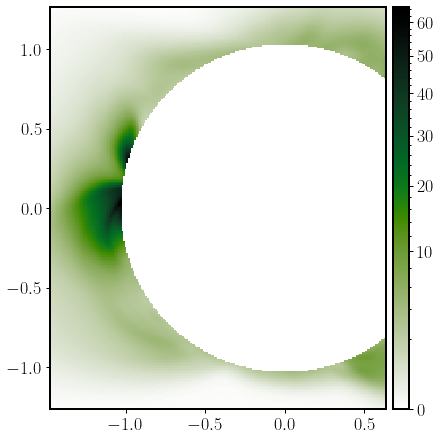

In [8]:
fig, ax = plt.subplots(figsize=(7,6),constrained_layout=True)

FeXIV_norm = ImageNormalize(data=FeXIV_int_sum,stretch=SqrtStretch(),vmin=0)
im = ax.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_int_sum,
              rasterized=True,cmap=cmr.jungle_r,shading="auto",norm=FeXIV_norm)

plot_colorbar(im,ax,width="5%",fontsize=18)

ax.set_aspect(1)
ax.tick_params(labelsize=18)

In [9]:
FeXIV_fitmodel = SpectrumFit2D(np.transpose(FeXIV_5303_profiles,(1,2,0)),wvl=FeXIV_5303_wvl,line_number=1,
                               line_wvl_init=5304.47,int_max_init=10,fwhm_init=1)
FeXIV_fitmodel.run_lse_mp(ncpu=4)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
 

In [10]:
FeXIV_lambd0_vaccum = 5304.4771

In [11]:
FeXIV_int_fit = FeXIV_fitmodel.int_total_fit[:,:,0]
FeXIV_int_fit[mask_disk] = np.nan
FeXIV_wvl_fit = FeXIV_fitmodel.line_wvl_fit[:,:,0]
FeXIV_wvl_fit[mask_disk] = np.nan
FeXIV_vlos_fit = -(FeXIV_wvl_fit - FeXIV_lambd0_vaccum)/FeXIV_lambd0_vaccum*const.c.cgs.value/1e5
FeXIV_fwhm_fit = FeXIV_fitmodel.fwhm_fit[:,:,0]
FeXIV_fwhm_fit[mask_disk] = np.nan
FeXIV_veff_fit = FeXIV_fwhm_fit/FeXIV_lambd0_vaccum/np.sqrt(4*np.log(2))*const.c.cgs.value/1e5

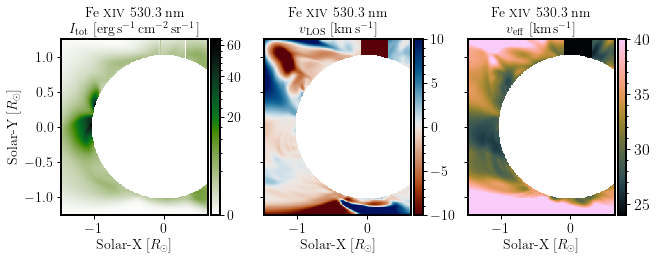

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(9,3.5),constrained_layout=True)

FeXIV_int_norm = ImageNormalize(data=FeXIV_int_fit,stretch=SqrtStretch(),vmin=0)
im1 = ax1.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_int_fit,
              rasterized=True,cmap=cmr.jungle_r,shading="auto",norm=FeXIV_int_norm)
plot_colorbar(im1,ax1,width="6%",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 530.3 nm" + "\n" + \
            r"$I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=14)


im2 = ax2.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_vlos_fit,
              rasterized=True,cmap=cmcm.vik_r,shading="auto",vmin=-10,vmax=10)
plot_colorbar(im2,ax2,width="6%",fontsize=14)
ax2.set_title(r"Fe \textsc{xiv} 530.3 nm" + "\n" + \
            r"$v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax2.tick_params(labelleft=False)

im3 = ax3.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_veff_fit,
              rasterized=True,cmap=cmcm.batlowK,shading="auto",vmin=24,vmax=40)
plot_colorbar(im3,ax3,width="6%",fontsize=16)
ax3.set_title(r"Fe \textsc{xiv} 530.3 nm" + "\n" + \
                r"$v_{\rm eff}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax3.tick_params(labelleft=False)
ax1.set_ylabel(r"Solar-Y $[R_\odot]$",fontsize=14)

for ax_ in (ax1,ax2,ax3):
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlabel(r"Solar-X $[R_\odot]$",fontsize=14)


In [13]:
FeX_6374_idlsav = readsav(FeX_6374_file)
FeX_6374_wvl = FeX_6374_idlsav["x"][2,:,0,0]
FeX_6374_x_mesh = FeX_6374_idlsav["x"][0,0,:,:]
FeX_6374_y_mesh = FeX_6374_idlsav["x"][1,0,:,:]
FeX_6374_profiles = FeX_6374_idlsav["w"]

In [14]:
FeX_fitmodel = SpectrumFit2D(np.transpose(FeX_6374_profiles,(1,2,0)),wvl=FeX_6374_wvl,line_number=1,
                               line_wvl_init=6376.2900,int_max_init=10,fwhm_init=1)
FeX_fitmodel.run_lse_mp(ncpu=4)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
 

In [15]:
FeX_lambd0_vaccum = 6376.2900

In [16]:
FeX_int_fit = FeX_fitmodel.int_total_fit[:,:,0]
FeX_int_fit[mask_disk] = np.nan
FeX_wvl_fit = FeX_fitmodel.line_wvl_fit[:,:,0]
FeX_wvl_fit[mask_disk] = np.nan
FeX_vlos_fit = -(FeX_wvl_fit - FeX_lambd0_vaccum)/FeX_lambd0_vaccum*const.c.cgs.value/1e5
FeX_fwhm_fit = FeX_fitmodel.fwhm_fit[:,:,0]
FeX_fwhm_fit[mask_disk] = np.nan
FeX_veff_fit = FeX_fwhm_fit/FeX_lambd0_vaccum/np.sqrt(4*np.log(2))*const.c.cgs.value/1e5

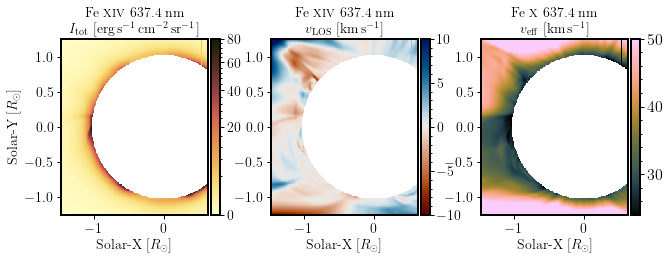

In [19]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(9,3.5),constrained_layout=True)

FeX_int_norm = ImageNormalize(data=FeX_int_fit,stretch=SqrtStretch(),vmin=0,vmax=80)
im1 = ax1.pcolormesh(FeX_6374_x_mesh,FeX_6374_y_mesh,FeX_int_fit,
              rasterized=True,cmap=cmcm.lajolla,shading="auto",norm=FeX_int_norm)
plot_colorbar(im1,ax1,width="6%",fontsize=14)

ax1.set_title(r"Fe \textsc{xiv} 637.4 nm" + "\n" + \
            r"$I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=14)


im2 = ax2.pcolormesh(FeX_6374_x_mesh,FeX_6374_y_mesh,FeX_vlos_fit,
              rasterized=True,cmap=cmcm.vik_r,shading="auto",vmin=-10,vmax=10)
plot_colorbar(im2,ax2,width="6%",fontsize=14)
ax2.set_title(r"Fe \textsc{xiv} 637.4 nm" + "\n" + \
            r"$v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)

im3 = ax3.pcolormesh(FeX_6374_x_mesh,FeX_6374_y_mesh,FeX_veff_fit,
              rasterized=True,cmap=cmcm.batlowK,shading="auto",vmin=24,vmax=50)
plot_colorbar(im3,ax3,width="6%",fontsize=16)
ax3.set_title(r"Fe \textsc{x} 637.4 nm" + "\n" + \
                r"$v_{\rm eff}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax1.set_ylabel(r"Solar-Y $[R_\odot]$",fontsize=14)

for ax_ in (ax1,ax2,ax3):
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlabel(r"Solar-X $[R_\odot]$",fontsize=14)
